In [3]:
import pm4py
import pandas as pd
import conformance_checker as cc

In [4]:


# log = pm4py.read_xes('./event_logs/test_event_log.xes')
log,_ = cc.fetch_event_log("28d2024790065ba320fd009ac8c575864e7670e5e4adee594ad4cb379e8652c3f43377808939bb10dc9a1e2e4e0f9a366ed403c60322d00cd2a52ccfe70327d5")
log.head()

parsing log, completed traces :: 100%|██████████| 34/34 [00:00<00:00, 8183.07it/s]
/Users/lakhoune/Desktop/Repos/mobsos-event-log-generator/.venv/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/Users/lakhoune/Desktop/Repos/mobsos-event-log-generator/.venv/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/Users/lakhoune/Desktop/Repos/mobsos-event-log-generator/.venv/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so 

,EVENT,concept:name,time:timestamp,lifecycle:transition,RESOURCE,RESOURCE_TYPE,REMARKS,case:concept:name
0,SERVICE_REQUEST,getMenu,2023-07-30 09:51:17+00:00,start,28d2024790065ba320fd009ac8c575864e7670e5e4adee...,bot,{},ba5a024c-4fd1-4b76-a0dd-815df1534d3a
1,SERVICE_REQUEST,getMenu,2023-07-30 09:51:17+00:00,complete,28d2024790065ba320fd009ac8c575864e7670e5e4adee...,bot,{},ba5a024c-4fd1-4b76-a0dd-815df1534d3a
2,SERVICE_REQUEST,getMenu,2023-07-30 09:51:34+00:00,start,28d2024790065ba320fd009ac8c575864e7670e5e4adee...,bot,{},b6755b3c-93ec-4884-8e85-c142bfcdc429
3,SERVICE_REQUEST,getMenu,2023-07-30 09:51:35+00:00,complete,28d2024790065ba320fd009ac8c575864e7670e5e4adee...,bot,{},b6755b3c-93ec-4884-8e85-c142bfcdc429
4,SERVICE_REQUEST,getMenu,2023-07-30 09:51:42+00:00,start,28d2024790065ba320fd009ac8c575864e7670e5e4adee...,bot,{},2f77046f-14d7-487e-b603-52d8b2ce8666


# Discovered Model

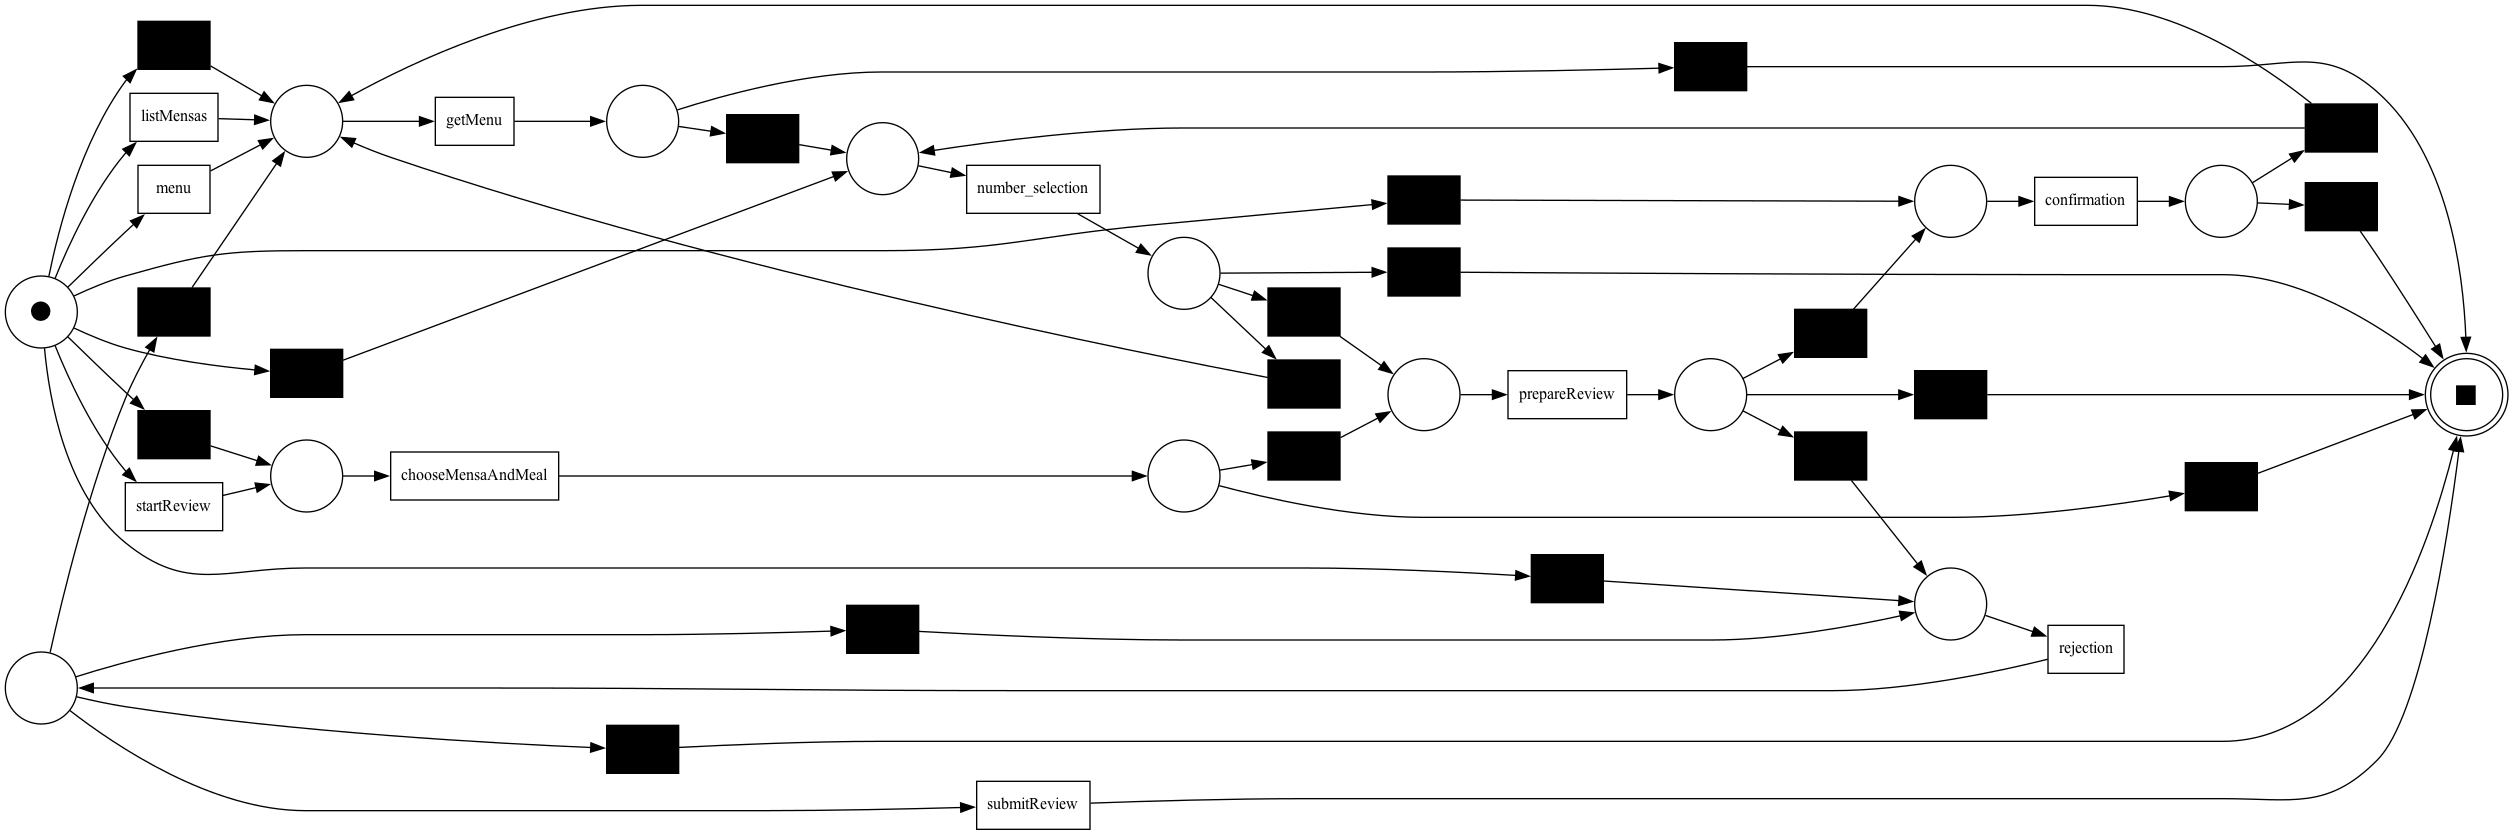

In [5]:

log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])
log =log[(log['EVENT'] == 'SERVICE_REQUEST') | (log['EVENT'] == 'USER_MESSAGE')]
log = log[(log['lifecycle:transition'] == 'complete') ]

net,im,fm = pm4py.discover_petri_net_heuristics(log)
pm4py.view_petri_net(net,im,fm)

In [6]:
traces = pm4py.get_variants(log)
traces

{('thanks',): 3,
 ('confirmation',): 3,
 ('listMensas', 'getMenu'): 1,
 ('greeting',): 5,
 ('getMenu',): 9,
 ('rejection', 'getMenu'): 1,
 ('startReview',
  'chooseMensaAndMeal',
  'prepareReview',
  'confirmation',
  'number_selection',
  'prepareReview'): 1,
 ('menu', 'getMenu'): 3,
 ('number_selection', 'getMenu'): 1,
 ('startReview',
  'chooseMensaAndMeal',
  'prepareReview',
  'rejection',
  'rejection'): 1,
 ('listMensas', 'getMenu', 'number_selection', 'getMenu'): 1,
 ('help',): 1,
 ('number_selection',): 1,
 ('confirmation', 'getMenu'): 1,
 ('chooseMensaAndMeal',): 1,
 ('rejection', 'submitReview'): 1}

# Bot Model

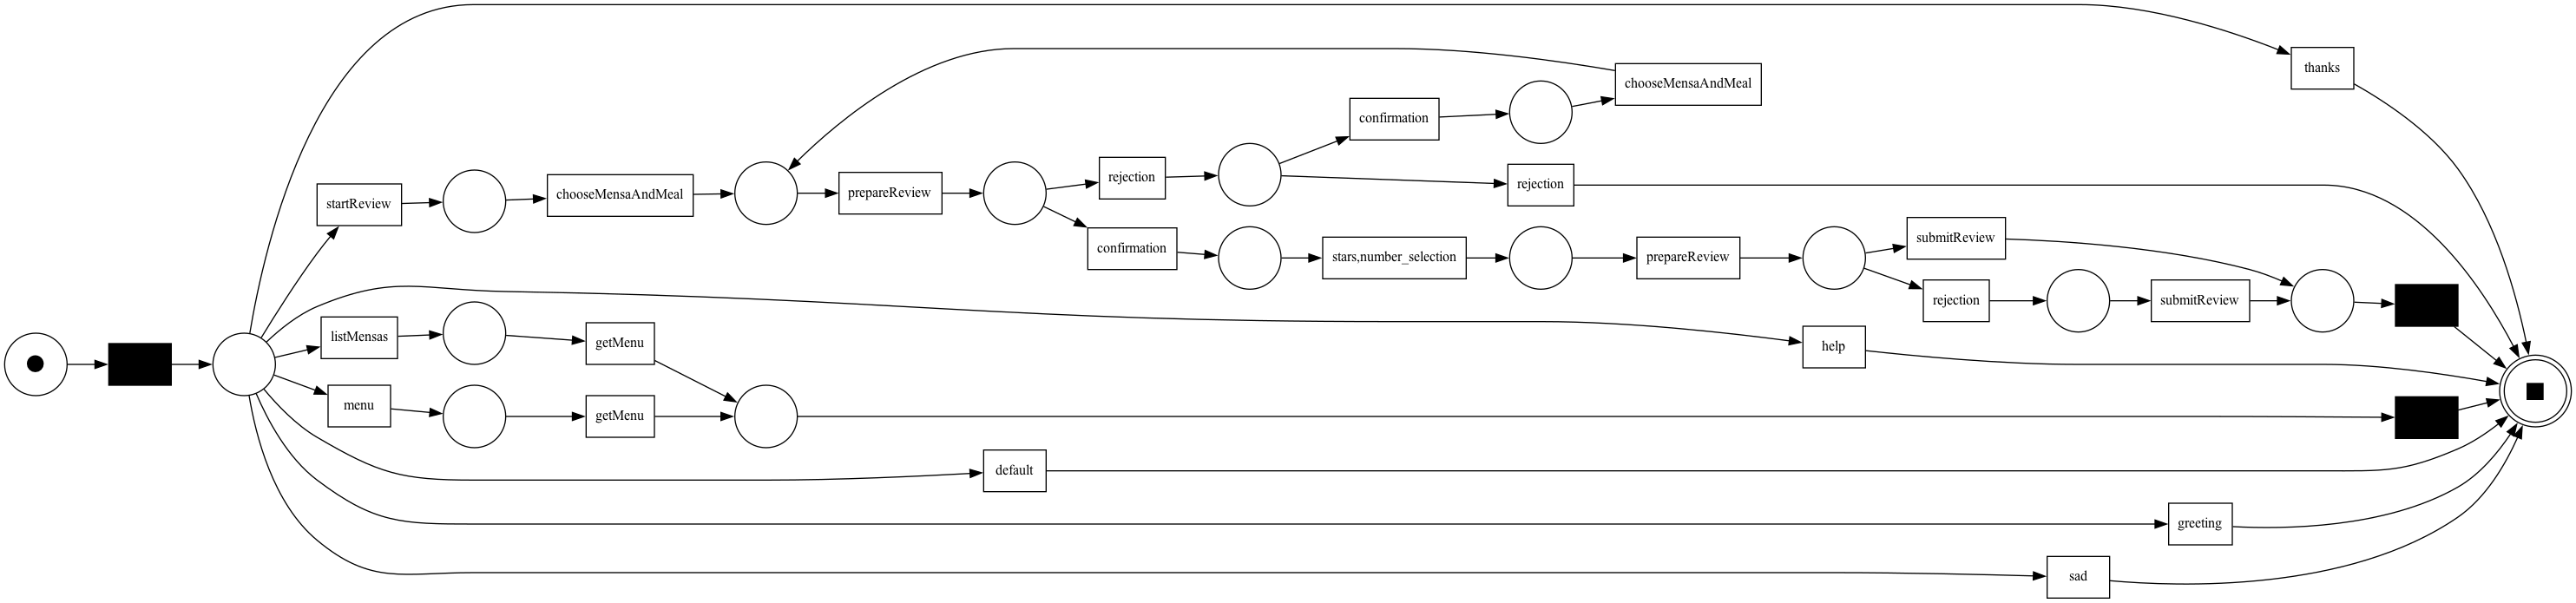

In [7]:
model = cc.load_bot_model()
bot_net,bot_im,bot_fm= cc.to_petri_net(model)
bot_net=pm4py.reduce_petri_net_invisibles(bot_net)
pm4py.view_petri_net(bot_net,bot_im,bot_fm)

In [8]:
# save the petri net
print(pm4py.llm.abstract_petri_net(bot_net, bot_im, bot_fm))

fitness = pm4py.fitness_token_based_replay(log,bot_net,bot_im,bot_fm)
fitness



If I have a Petri net:

places: [ 260085832f8353a7941f715b, 2737c217b4ca167946a11531, 3b995f08d360475619d5dead, 634a4745877740ed163a77fa, 7169854c636b80c0a1dd7639, 79552d31107b16eafdcb5fe3, 8631a4c087becb9236bcafbb, 9b1dbda718ab29d02cf45d48, 9df99e13096da83d093358fb, a2328d74750c839062ebabb0, b3bb240b54166af91c94ce4b, b83a85b73e0b1ed74ed0091e, d94ff20cab73cf98782a9efc, f8f8142fd272fb35e933c7d4, sink, source ]
transitions: [ (0d6daa47e7c34171bba39dbd_28, 'rejection'), (117e0d66e833fb189e661891_24, 'help'), (260085832f8353a7941f715b_10, 'getMenu'), (260085832f8353a7941f715b_19, 'getMenu'), (260085832f8353a7941f715b_4, None), (2737c217b4ca167946a11531_25, 'listMensas'), (2cf567110bae35efe71a5cdf_23, 'greeting'), (3b995f08d360475619d5dead_21, 'menu'), (634a4745877740ed163a77fa_12, 'rejection'), (7169854c636b80c0a1dd7639_14, 'prepareReview'), (79552d31107b16eafdcb5fe3_11, 'prepareReview'), (8631a4c087becb9236bcafbb_27, 'chooseMensaAndMeal'), (8631a4c087becb9236bcafbb_30, 'chooseMensaAndMe

replaying log with TBR, completed variants :: 100%|██████████| 16/16 [00:00<00:00, 6267.17it/s]


{'perc_fit_traces': 41.1764705882353,
 'average_trace_fitness': 0.6876750700280112,
 'log_fitness': 0.7586206896551724,
 'percentage_of_fitting_traces': 41.1764705882353}

In [9]:
diagnostics = pm4py.conformance_diagnostics_alignments(log,net,im,fm)
# filter for fitness less than 1
unfitting = list(trace for trace in diagnostics if trace['fitness'] < 1)
fitting = list(trace for trace in diagnostics if trace['fitness']==1)
unfitting

aligning log, completed variants :: 100%|██████████| 16/16 [00:00<00:00, 585.21it/s]


[{'alignment': [('thanks', '>>'),
   ('>>', None),
   ('>>', 'confirmation'),
   ('>>', None)],
  'cost': 20002,
  'visited_states': 4,
  'queued_states': 20,
  'traversed_arcs': 20,
  'lp_solved': 1,
  'fitness': 0.0,
  'bwc': 20002},
 {'alignment': [('thanks', '>>'),
   ('>>', None),
   ('>>', 'confirmation'),
   ('>>', None)],
  'cost': 20002,
  'visited_states': 4,
  'queued_states': 20,
  'traversed_arcs': 20,
  'lp_solved': 1,
  'fitness': 0.0,
  'bwc': 20002},
 {'alignment': [('greeting', '>>'),
   ('>>', None),
   ('>>', 'confirmation'),
   ('>>', None)],
  'cost': 20002,
  'visited_states': 4,
  'queued_states': 20,
  'traversed_arcs': 20,
  'lp_solved': 4,
  'fitness': 0.0,
  'bwc': 20002},
 {'alignment': [('greeting', '>>'),
   ('>>', None),
   ('>>', 'confirmation'),
   ('>>', None)],
  'cost': 20002,
  'visited_states': 4,
  'queued_states': 20,
  'traversed_arcs': 20,
  'lp_solved': 4,
  'fitness': 0.0,
  'bwc': 20002},
 {'alignment': [('startReview', 'startReview'),
   (